In [ ]:
import streamlit as st
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.io import MemoryFile
from rasterio.transform import Affine
from streamlit_image_coordinates import streamlit_image_coordinates

# --------------------------------------------------
# CONFIG
# --------------------------------------------------
st.set_page_config(layout="wide")
st.title("Flood Mapping using Sentinel Imagery")

# --------------------------------------------------
# HELPERS
# --------------------------------------------------
def read_uploaded_raster(uploaded_file):
    with MemoryFile(uploaded_file.read()) as memfile:
        with memfile.open() as src:
            data = src.read()
            profile = src.profile
    return data, profile

def normalize(img, pmin=2, pmax=98):
    vmin = np.nanpercentile(img, pmin)
    vmax = np.nanpercentile(img, pmax)
    return np.clip((img - vmin) / (vmax - vmin), 0, 1)

# --------------------------------------------------
# SIDEBAR: FILE UPLOADS
# --------------------------------------------------
st.sidebar.header("Upload images")

s1_file_1 = st.sidebar.file_uploader("Pre-Flood Sentinel-1", type=["tif", "tiff"])
s1_file_2 = st.sidebar.file_uploader("Post-Flood Sentinel-1", type=["tif", "tiff"])
s2_file   = st.sidebar.file_uploader("Sentinel-2 Monthly Composite", type=["tif", "tiff"])

st.sidebar.markdown("---")

vv_thresh = st.sidebar.slider(
    "VV threshold (normalized)",
    0.0, 1.0, 0.2, 0.01
)

mask_opacity = st.sidebar.slider(
    "Mask opacity",
    0.0, 1.0, 0.5, 0.05
)

generate = st.sidebar.button("Generate flood mask")

# --------------------------------------------------
# LOAD DATA
# --------------------------------------------------
if not (s1_file_1 and s1_file_2 and s2_file):
    st.info("Upload two Sentinel-1 VV images and one Sentinel-2 RGB image.")
    st.stop()

s1_1, s1_profile = read_uploaded_raster(s1_file_1)
s1_2, _          = read_uploaded_raster(s1_file_2)
s2,   s2_profile = read_uploaded_raster(s2_file)

s1_1 = s1_1[0]
s1_2 = s1_2[0]
s2_rgb = np.transpose(s2[:3], (1, 2, 0))

s1_1_n = normalize(s1_1)
s1_2_n = normalize(s1_2)
s2_n   = normalize(s2_rgb)

# --------------------------------------------------
# TOP ROW: SENTINEL-1
# --------------------------------------------------
col1, col2 = st.columns(2)

with col1:
    st.subheader("Sentinel-1 - Date 1 (VV)")
    fig1, ax1 = plt.subplots()
    ax1.imshow(s1_1_n, cmap="gray")
    ax1.axis("off")
    st.pyplot(fig1)

with col2:
    st.subheader("Sentinel-1 - Date 2 (VV)")
    fig2, ax2 = plt.subplots()
    ax2.imshow(s1_2_n, cmap="gray")
    ax2.axis("off")
    st.pyplot(fig2)

# --------------------------------------------------
# BOTTOM PANEL: INTERACTIVE DISPLAY
# --------------------------------------------------
st.subheader("Sentinel-2 with Sentinel-1 Mask (Zoom & Pan Enabled)")

mask = None
mask_rgba = None

if generate:
    mask = (s1_1_n < vv_thresh) & (s1_2_n < vv_thresh)

    mask_rgba = np.zeros((*mask.shape, 4))
    mask_rgba[..., 0] = 1.0
    mask_rgba[..., 3] = mask * mask_opacity

# Create composite image
fig3, ax3 = plt.subplots(figsize=(10, 6))
ax3.imshow(s2_n)
if mask_rgba is not None:
    ax3.imshow(mask_rgba)
ax3.axis("off")

# Interactive zoomable display
coords = streamlit_image_coordinates(fig3, key="zoom_view")

# --------------------------------------------------
# EXPORTS
# --------------------------------------------------
st.markdown("### Export")

col_exp1, col_exp2 = st.columns(2)

with col_exp1:
    if generate:
        fig3.canvas.draw()
        png_path = "sentinel1_mask_overlay.png"
        fig3.savefig(png_path, dpi=300)

        with open(png_path, "rb") as f:
            st.download_button(
                "Export displayed image (PNG)",
                f,
                file_name="sentinel1_mask_on_sentinel2.png",
                mime="image/png"
            )

with col_exp2:
    if generate:
        mask_tif_path = "sentinel1_mask.tif"

        profile = s1_profile.copy()
        profile.update(
            dtype=rasterio.uint8,
            count=1,
            nodata=0,
            compress="lzw"
        )

        with rasterio.open(mask_tif_path, "w", **profile) as dst:
            dst.write(mask.astype(np.uint8), 1)

        with open(mask_tif_path, "rb") as f:
            st.download_button(
                "Export mask as GeoTIFF",
                f,
                file_name="sentinel1_mask.tif",
                mime="image/tiff"
            )


2025-12-14 00:55:44.879 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-14 00:55:44.881 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-14 00:55:44.882 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-14 00:55:44.929 
  command:

    streamlit run c:\Users\FRAN\anaconda3\envs\fran_ipa\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-12-14 00:55:44.930 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-14 00:55:44.932 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-14 00:55:44.933 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-14 00:55:44.935 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored 

AttributeError: 'NoneType' object has no attribute 'read'

In [72]:
"""
PURPOSE: Generate flood maps and raster masks using Sentinel-1 SAR and Sentinel-2 optical imagery.

INPUTS: Sentinel 1 image during peak and post flood dates. Monthly composite of Sentinel-2 RGB for overlay.
Images were preprocessed (compositing, mosaicking, cloudmasking) on Google Earth Engine to lessen file size.

ChatGPT 4 and 5 was used in creating a template for the Streamlit app and debugging errors regarding the download button, session_states, and matplotlib visualizations.

REFERENCES:
Lee filter for despeckling using scipy: Groff (2017). Despeckling Synthetic Aperture Radar (SAR) Images. https://www.kaggle.com/code/jgroff/despeckling-synthetic-aperture-radar-sar-images.
S1 Water thresholding: McVittie (2019). STEP ESA Flood mapping tutorial. https://step.esa.int/docs/tutorials/tutorial_s1floodmapping.pdf
Streamlit widgets documentation. https://docs.streamlit.io/develop.
"""

import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.io import MemoryFile
from rasterio.transform import Affine
from scipy.ndimage import uniform_filter
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch



def read_uploaded_raster(uploaded_file):
    with MemoryFile(uploaded_file.read()) as memfile:
        with memfile.open() as src:
            data = src.read()
            profile = src.profile
    # print("####### SENTINEL IMAGES AY", type(data), data.shape)
    return data, profile

def db_to_linear(db_array):
    """Convert dB to linear scale, skipping NaNs."""
    lin = np.full_like(db_array, np.nan, dtype=np.float32)
    mask = ~np.isnan(db_array)
    lin[mask] = 10 ** (db_array[mask] / 10)
    return lin

def linear_to_db(lin_array):
    """Convert linear to dB safely, avoiding log(0)."""
    db = np.full_like(lin_array, np.nan, dtype=np.float32)
    mask = ~np.isnan(lin_array)
    db[mask] = 10 * np.log10(np.maximum(lin_array[mask], 1e-8))
    return db

def lee_filter(img, size):
    """Lee speckle filter with NaN handling."""
    # Replace NaNs with 0 temporarily for convolution
    img_filled = np.nan_to_num(img, nan=0.0)
    
    # Local mean and variance
    mean = uniform_filter(img_filled, size)
    mean_sq = uniform_filter(img_filled**2, size)
    var = mean_sq - mean**2
    
    # Noise variance
    noise_var = np.nanmean(var)
    
    # Lee weighting
    w = var / (var + noise_var)
    result = mean + w * (img_filled - mean)
    
    # Restore NaNs for NoData
    result[np.isnan(img)] = np.nan
    return result


# FILE UPLOADS -------------------------------------------------- 

# st.header("Upload images")
# st.subheader("Sentinel-1 Peak Flood")
# s1_peak_file = st.file_uploader("The Sentinel-1 Image RIGHT AFTER the typhoon arrival date captures the areas that experienced peak flooding.", type=["tif", "tiff"], help="Sentinel-1 Image closest to typhoon arrival date")
# s1_peak_date = st.date_input("Enter peak-flood image capture date", value="today")
# st.subheader("Sentinel-1 Post Flood")
# s1_post_file = st.file_uploader("The Sentinel-1 Image AFTER THE PEAK FLOOD captures the areas where flooding has not subsided yet.", type=["tif", "tiff"])
# s1_post_date = st.date_input("Enter post-flood image capture date", value="today")
# st.subheader("Sentinel 2 for Basemap")
# s2_file   = st.file_uploader("Sentinel-2 RGB (Current version assumes that the raster only contains bands 2, 3, & 4 to minimize file size.)", type=["tif", "tiff"])

s1_peak_file = fr"D:\Users\FRAN\Documents\IPA\GUI_project\ipa_floodmap_samples\bago_s1_20251104_peak.tif"
s1_post_file = fr"D:\Users\FRAN\Documents\IPA\GUI_project\ipa_floodmap_samples\bago_s1_20251116_post.tif"
s2_file = fr"D:\Users\FRAN\Documents\IPA\GUI_project\ipa_floodmap_samples\bago_s2_202511_comp.tif"
vv_thresh = (-20.0, -15.0)
mask_opacity = 1
s1_peak_date, s1_post_date = 888, 888

In [73]:
s1_1 = rasterio.open(s1_peak_file).read()
s1_profile = rasterio.open(s1_peak_file).profile
s1_2 = rasterio.open(s1_post_file).read()
s2 = rasterio.open(s2_file).read(masked=True)
s2_profile = rasterio.open(s2_file).profile

# assumes VV is first band
s1_peak = s1_1[0] 
s1_post = s1_2[0]
print(s2.shape)
# gets first 3 bands since s2 also has nir; changes shape from (band,row,col) to (row,col,band); switches bands 1 and 3 to get RGB from BGR
s2_rgb = np.transpose(s2[:3], (1, 2, 0))[:, :, ::-1] 
s2_rgb = s2_rgb/10000 # to scale values from 0 to 1
print(np.nanmin(s2_rgb), np.nanmax(s2_rgb))
# np.histogram(s2)


(4, 2019, 3692)
0.0 1.0672


In [ ]:
# print(s2.shape)
# # gets first 3 bands since s2 also has nir; changes shape from (band,row,col) to (row,col,band); switches bands 1 and 3 to get RGB from BGR
# s2_rgb = np.transpose(s2[:3], (1, 2, 0))[:, :, ::-1] 
# s2_rgb = s2_rgb/10000 # to scale values from 0 to 1
# print(np.nanmin(s2_rgb), np.nanmax(s2_rgb))
# # np.histogram(s2)


(4, 2019, 3692)
(2019, 3692, 3)
0.0 1.0672


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0230245028756244].


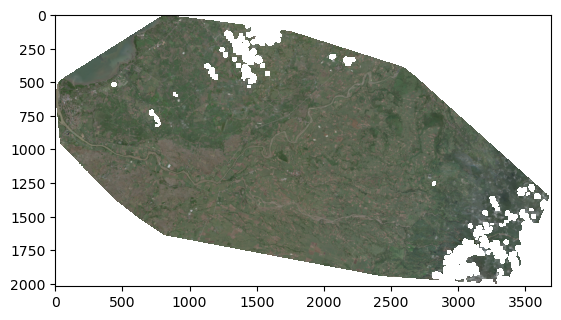

In [33]:
def percentile_stretch(array, lower=0, upper=100):
    """Apply percentile-based contrast stretching"""
    percentiles = np.percentile(array, (lower, upper))
    stretched = np.clip(array, percentiles[0], percentiles[1])
    return (stretched - percentiles[0]) / (percentiles[1] - percentiles[0])

# plt.imshow(percentile_stretch(s2_rgb))
# plt.imshow(s2_rgb)
gamma=0.35
plt.imshow(np.power(s2_rgb, gamma), )
plt.show()

Applying uniform filter to reduce speckle noise in S1 images


C:\Users\FRAN\AppData\Local\Temp\ipykernel_3696\558089713.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
C:\Users\FRAN\AppData\Local\Temp\ipykernel_3696\558089713.py:82: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()
C:\Users\FRAN\AppData\Local\Temp\ipykernel_3696\558089713.py:91: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig3.show()
C:\Users\FRAN\AppData\Local\Temp\ipykernel_3696\558089713.py:96: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig4.show()
C:\Users\FRAN\AppData\Local\Temp\ipykernel_3696\558089713.py:132: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig3.show()
C:\Users\FRAN\AppData\Local\Temp\ipykernel_3696\558089713.py:139: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig4.show()


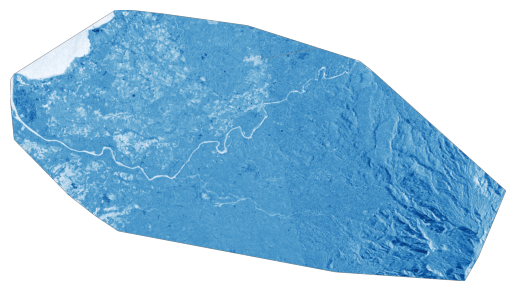

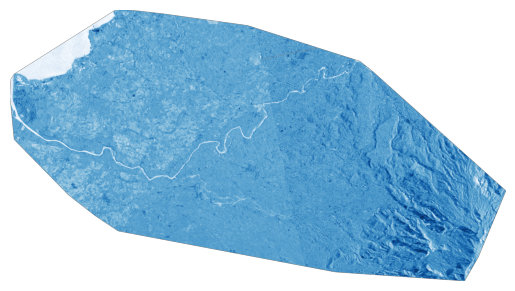

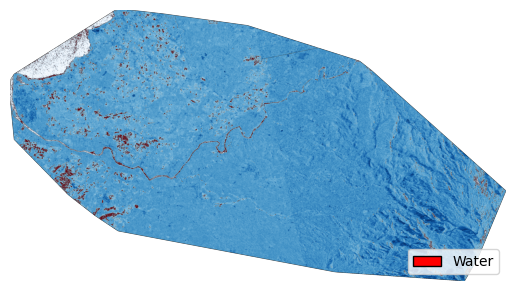

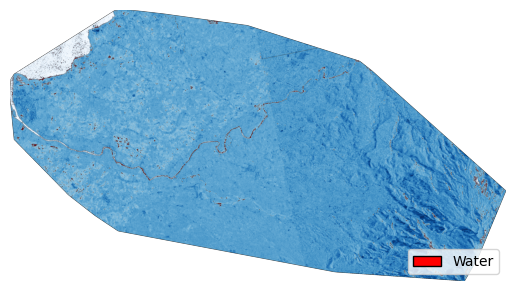

In [ ]:


# st.markdown("---")

# st.header("Flood Mask Parameters")
# vv_thresh = st.slider(
#     "Select VV thresholds for Water (Default values have been set to the standard water threshold for Sentinel-1 VV images)",
#     min_value=-50.0, max_value=1.0, value=(-20.0, -15.0),
#     format="%0.3f"
# )

# mask_opacity = st.slider("Mask opacity", min_value=0.0, max_value=1.0, value=1.0)

# load_imgs = st.button("Load images", type="secondary")
# despeckle = st.button("Despeckle images", type="secondary")
# generate = st.button("Generate mask", type="primary")

# st.markdown("---")

# --------------------------------------------------
# LOAD DATA
# --------------------------------------------------
# if not (s1_peak_file and s1_post_file and s2_file):
#     st.info("Upload two Sentinel-1 VV images and one Sentinel-2 RGB image.")
#     st.stop()

# s1_1, s1_profile = read_uploaded_raster(s1_peak_file)
# s1_2, _          = read_uploaded_raster(s1_post_file)
# s2,   s2_profile = read_uploaded_raster(s2_file)



# # TO MAINTAIN LOADED IMAGES ------------------------

# if "show_loaded" not in st.session_state:
#     st.session_state.show_loaded = False

# if "show_despeckled" not in st.session_state:
#     st.session_state.show_despeckled = False

# # --------------------------------------------------
# # TOP ROW: SENTINEL-1
# # --------------------------------------------------
# col1, col2 = st.columns(2)

# # with col1:
#     st.subheader(f"Sentinel-1 - {s1_peak_date} (VV)")
fig1, ax1 = plt.subplots()
ax1.axis("off")

# with col2:
#     st.subheader(f"Sentinel-1 - {s1_post_date} (VV)")
fig2, ax2 = plt.subplots()
ax2.axis("off")

print("Applying uniform filter to reduce speckle noise in S1 images")

# col3, col4 = st.columns(2)
# with col3:
    # st.subheader(f"Sentinel-1 - {s1_peak_date} (VV)")
fig3, ax3 = plt.subplots()
ax3.axis("off")

# with col4:
    # st.subheader(f"Sentinel-1 - {s1_peak_date} (VV)")
fig4, ax4 = plt.subplots()
ax4.axis("off")

s1_peak_despeckled = linear_to_db(lee_filter(db_to_linear(s1_peak), size=5))
s1_post_despeckled = linear_to_db(lee_filter(db_to_linear(s1_post), size=5))

# # WHEN LOAD IMAGES BUTTON IS CLICKED --------------------------------------------------
# if load_imgs:
#     st.session_state.show_loaded = True

# if st.session_state.show_loaded:
#     with col1:
ax1.imshow(s1_peak, cmap="Blues", vmin=-25, vmax=5)
fig1.show()
        # st.pyplot(fig1, clear_figure=False)
    
    # with col2:
ax2.imshow(s1_post, cmap="Blues", vmin=-25, vmax=5)
fig2.show()

# # WHEN DESPECKLE BUTTON IS CLICKED --------------------------------------------------
# if despeckle:
#     st.session_state.show_despeckled = True

# if st.session_state.show_despeckled:
    # with col3:
ax3.imshow(s1_peak_despeckled, cmap="Blues", vmin=-25, vmax=5)
fig3.show()
        # st.pyplot(fig3, clear_figure=False)
    
    # with col4:
ax4.imshow(s1_post_despeckled, cmap="Blues", vmin=-25, vmax=5)
fig4.show()
        # st.pyplot(fig4, clear_figure=False)

# --------------------------------------------------
# BOTTOM PANEL: INTERACTIVE DISPLAY
# --------------------------------------------------


# WHEN GENERATE BUTTON IS CLICKED --------------------------------------------------

mask_peak, mask_post, mask_rgb = None, None, None
# if "show_mask" not in st.session_state:
#     st.session_state.show_mask = False

# if generate:
#     st.session_state.show_mask = True

# if st.session_state.show_mask:
mask_peak = ( (s1_peak > vv_thresh[0]) & (s1_peak < vv_thresh[1]) ).astype(np.uint8) # VV VV > 0 AND VV < 0.025 
mask_peak = np.where(mask_peak == 1, 1, np.nan)
mask_post = ( (s1_post > vv_thresh[0]) & (s1_post < vv_thresh[1]) ).astype(np.uint8)
mask_post = np.where(mask_post == 1, 1, np.nan)

"""
1 = water in peak flood only
10 = water in post flood only
11 = water in both
0 = no water
"""
mask_peak_only = (mask_peak == 1) & (mask_post == 0)
mask_post_only = (mask_peak == 0) & (mask_post == 1)
mask_both      = (mask_peak == 1) & (mask_post == 1)
mask_rgb = np.zeros_like(mask_peak, dtype=np.uint8)
mask_rgb[mask_peak_only] = 1       # Peak flood only
mask_rgb[mask_post_only] = 10      # Post-flood only
mask_rgb[mask_both] = 11 
mask_rgb = np.where(mask_rgb is not np.nan, mask_rgb, np.nan)
    
    # col3, col4 = st.columns(2)
legend_elements = [Patch(facecolor="red", edgecolor="black", label="Water")]
    # with col3:
ax3.imshow(s1_peak_despeckled, cmap="Blues", vmin=-25, vmax=5)
ax3.imshow(mask_peak, cmap="Reds", vmin=0, vmax=1, alpha=mask_opacity)
ax3.legend(handles=legend_elements, loc="lower right", frameon=True)
fig3.show()
        # st.pyplot(fig3, clear_figure=False)
    
    # with col4:
ax4.imshow(s1_post_despeckled, cmap="Blues", vmin=-25, vmax=5)
ax4.imshow(mask_post, cmap="Reds", vmin=0, vmax=1, alpha=mask_opacity)
ax4.legend(handles=legend_elements, loc="lower right", frameon=True)
fig4.show()
        # st.pyplot(fig4, clear_figure=False)
    
    # st.pyplot(fig5, clear_figure=False)


# # DOWNLOAD FLOOD MASK BUTTON -----------------------------------
# def mask_to_geotiff_bytes(mask, reference_profile):
#     memfile = MemoryFile()
#     profile = reference_profile.copy()
#     profile.update(
#         driver="GTiff",
#         dtype=rasterio.uint8,
#         count=1,
#         nodata=0,
#         compress="lzw"
#     )

#     with memfile.open(**profile) as dst:
#         dst.write(mask.astype("uint8"), 1)

#     return memfile.read()

# if mask_rgb is not None:
#     mask_rgb_bytes = mask_to_geotiff_bytes(mask_rgb, s1_profile)

# st.download_button(
#     label="Download Flood Mask Raster",
#     data=mask_rgb_bytes,
#     file_name="floodmask.tif",
#     mime="image/tiff",
#     type="primary")

In [82]:
mask_peak = ( (s1_peak > vv_thresh[0]) & (s1_peak < vv_thresh[1]) ).astype(np.uint8) # VV VV > 0 AND VV < 0.025 
mask_post = ( (s1_post > vv_thresh[0]) & (s1_post < vv_thresh[1]) ).astype(np.uint8)
mask_rgb = mask_peak + mask_post*10
print(np.histogram(mask_peak, bins=[i for i in range(13)]))
print(np.histogram(mask_post, bins=[i for i in range(13)]))
print(np.histogram(mask_rgb, bins=[i for i in range(13)]))
print(np.min(mask_rgb), np.max(mask_rgb))

(array([7311267,  142881,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))
(array([7393619,   60529,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))
(array([7276663,  116956,       0,       0,       0,       0,       0,
             0,       0,       0,   34604,   25925]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))
0 11


In [ ]:
mask_rgb = mask_peak + mask_post*10
print(np.histogram(mask_rgb, bins=[i for i in range(13)]))



(array([7276663,  116956,       0,       0,       0,       0,       0,
             0,       0,       0,   34604,   25925]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))
0 11


In [56]:
print([i for i in range (1,12)])
print(np.histogram(mask_rgb, bins=[i for i in range(1,13)]))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(array([116956,      0,      0,      0,      0,      0,      0,      0,
            0,  34604,  25925]), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))


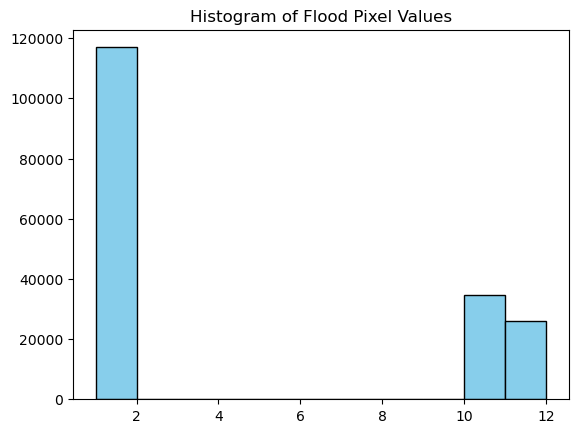

In [ ]:
mask_peak = ( (s1_peak > vv_thresh[0]) & (s1_peak < vv_thresh[1]) ).astype(np.uint8) # VV VV > 0 AND VV < 0.025 
mask_post = ( (s1_post > vv_thresh[0]) & (s1_post < vv_thresh[1]) ).astype(np.uint8)
mask_rgb = mask_peak + mask_post*10

Sentinel-2 with Sentinel-1 Flood Mask


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0230245028756244].
C:\Users\FRAN\AppData\Local\Temp\ipykernel_3696\4008891094.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig5.show()


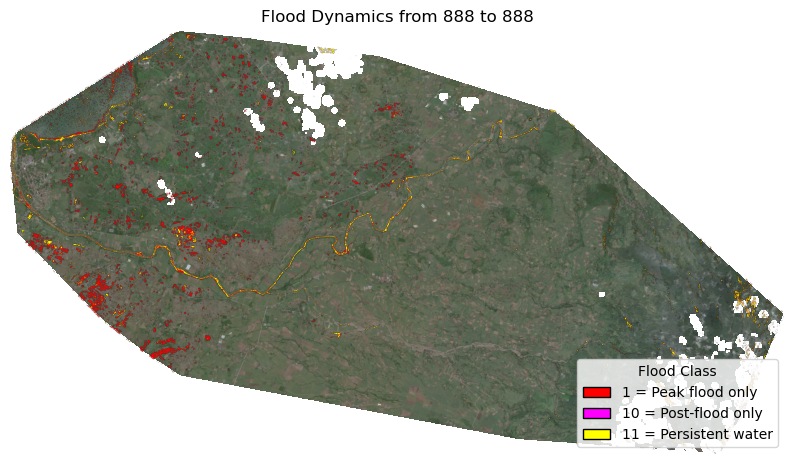

In [83]:

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))


print("Sentinel-2 with Sentinel-1 Flood Mask")

# Create composite image
fig5, ax5 = plt.subplots(figsize=(10, 6))
ax5.axis("off")


colors = ["white", "red", "fuchsia", "yellow"]
bounds = [0.0, 1.0, 10.0, 11.0]
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)
ax5.imshow(np.power(s2_rgb, gamma))
ax5.imshow(np.where(mask_rgb > 0, mask_rgb, np.nan), cmap=cmap, norm=norm, alpha=mask_opacity)
ax5.set_title(f"Flood Dynamics from {s1_peak_date} to {s1_post_date}")
legend_elements = [
    Patch(facecolor="red", edgecolor="black", label="1 = Peak flood only"),
    Patch(facecolor="fuchsia", edgecolor="black", label="10 = Post-flood only"),
    Patch(facecolor="yellow", edgecolor="black", label="11 = Persistent water"),
]
ax5.legend(handles=legend_elements, loc="lower right", frameon=True, title="Flood Class")
fig5.show()

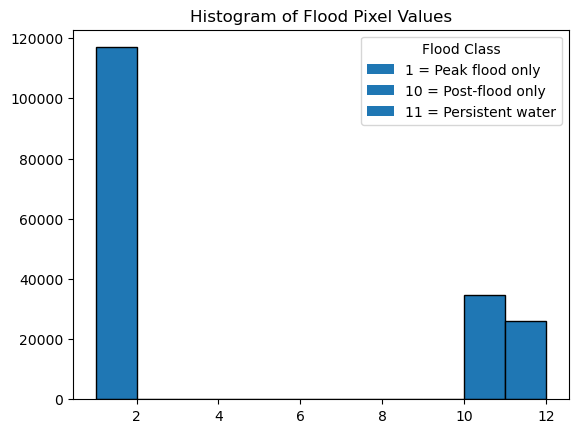

In [68]:
plt.hist(mask_rgb.flatten(), bins=[i for i in range(1,13)], edgecolor='black')
plt.title("Histogram of Flood Pixel Values")
legend_elements_hist = [
    Patch(label="1 = Peak flood only"),
    Patch(label="10 = Post-flood only"),
    Patch(label="11 = Persistent water"),
]
plt.legend(handles=legend_elements_hist, loc="upper right", frameon=True, title="Flood Class")

plt.show()